In [1]:
%reload_ext autoreload
%autoreload 2

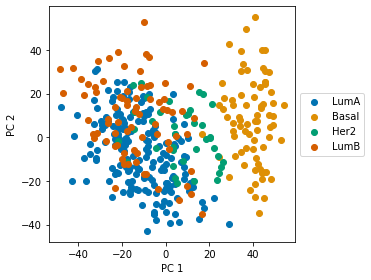

In [3]:
from spFA.spFA import spFA
from spFA.plots import plot_top_weights, plot_weights, plot_variance_explained_view,plot_variance_explained

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
from sklearn.preprocessing import StandardScaler

###############################################################################


##############################################################################
# 
torch.manual_seed(0)

rna = pd.read_csv("tcga/train_rna.csv", index_col=0)
mirna = pd.read_csv("tcga/train_mirna.csv", index_col=0)
prot = pd.read_csv("tcga/train_prot.csv", index_col=0)
meth = pd.read_csv("tcga/train_meth.csv", index_col=0)
subtype = pd.read_csv("tcga/train_y.csv", index_col=0)

rna_test = pd.read_csv("tcga/test_rna.csv", index_col=0)
mirna_test = pd.read_csv("tcga/test_mirna.csv", index_col=0)
prot_test = pd.read_csv("tcga/test_prot.csv", index_col=0)
meth_test = pd.read_csv("tcga/test_meth.csv", index_col=0)
subtype_test = pd.read_csv("tcga/test_y.csv", index_col=0)


scaler = StandardScaler()
rna = pd.DataFrame(scaler.fit_transform(rna), columns = rna.columns)
meth = pd.DataFrame(scaler.fit_transform(meth), columns = meth.columns)
mirna = pd.DataFrame(scaler.fit_transform(mirna), columns = mirna.columns)
prot = pd.DataFrame(scaler.fit_transform(prot), columns = prot.columns)

llh = ["gaussian", "gaussian", "gaussian", "gaussian"]
views = ["mrna", "methylation", "mirna", "proteomics"]
X = [torch.tensor(rna.values), torch.tensor(meth.values), torch.tensor(mirna.values),torch.tensor(prot.values)]

label_map = {lab:i for i,lab in enumerate(np.unique(subtype["x"]))}
y = np.array([label_map[i] for i in subtype["x"]])




cblind_colors = sns.color_palette("colorblind", as_cmap=True)[0:4]
subtypes = ["LumA", "Basal",  "Her2", "LumB"]
# plot pca of concatenated features
pca = PCA(2).fit_transform(np.hstack(X))
fig, ax = plt.subplots(1)
for i,sub in enumerate(subtypes):
    plot = ax.scatter(pca[subtype["x"].values==sub,0],pca[subtype["x"].values==sub,1], color=cblind_colors[i], label=sub)
ax.set_aspect('equal')
ax.set_aspect('equal')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("PCA.png", dpi=400)
plt.show()
plt.close()

In [7]:
#torch.set_num_threads(7)


model = sFA(X, 
            llh, 
            num_factors=5, 
            views=views, 
            y=torch.tensor(y), 
            target_llh = "multinomial", 
            supervised_factors=2,  
            device=torch.device('cuda'),
            ard=True,
            horseshoe=True)

model.fit_spFA(n_steps=3000, lr=0.01)

6659257.931248474
2254879.4402853586
2114177.7959890296
training done


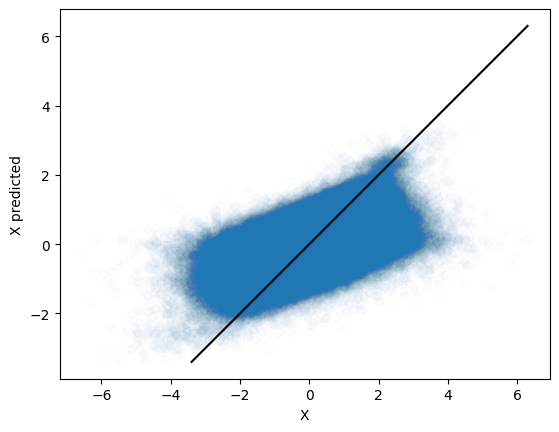

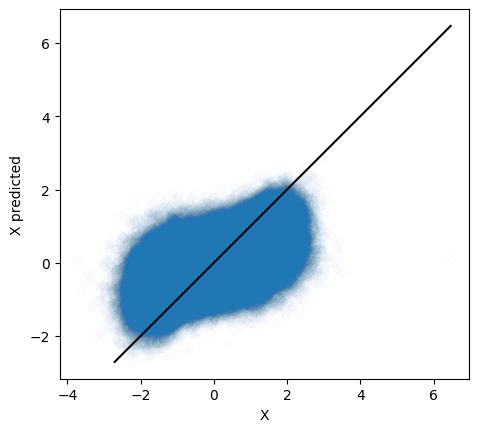

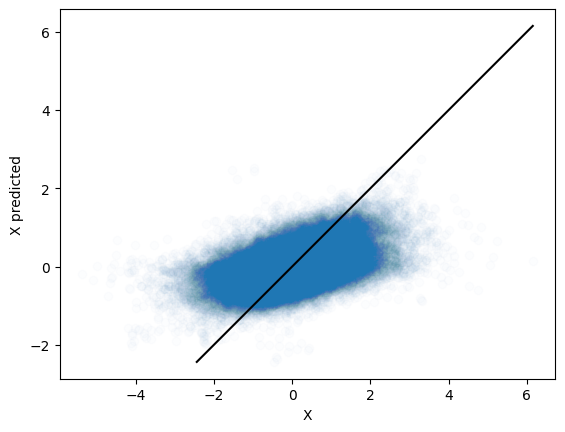

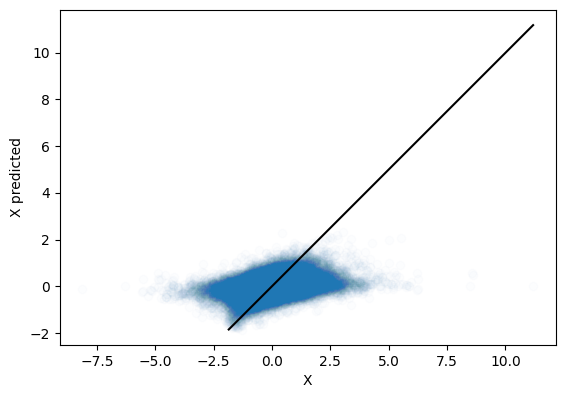

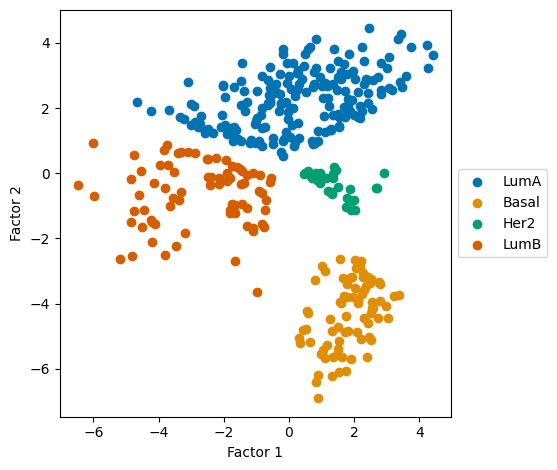

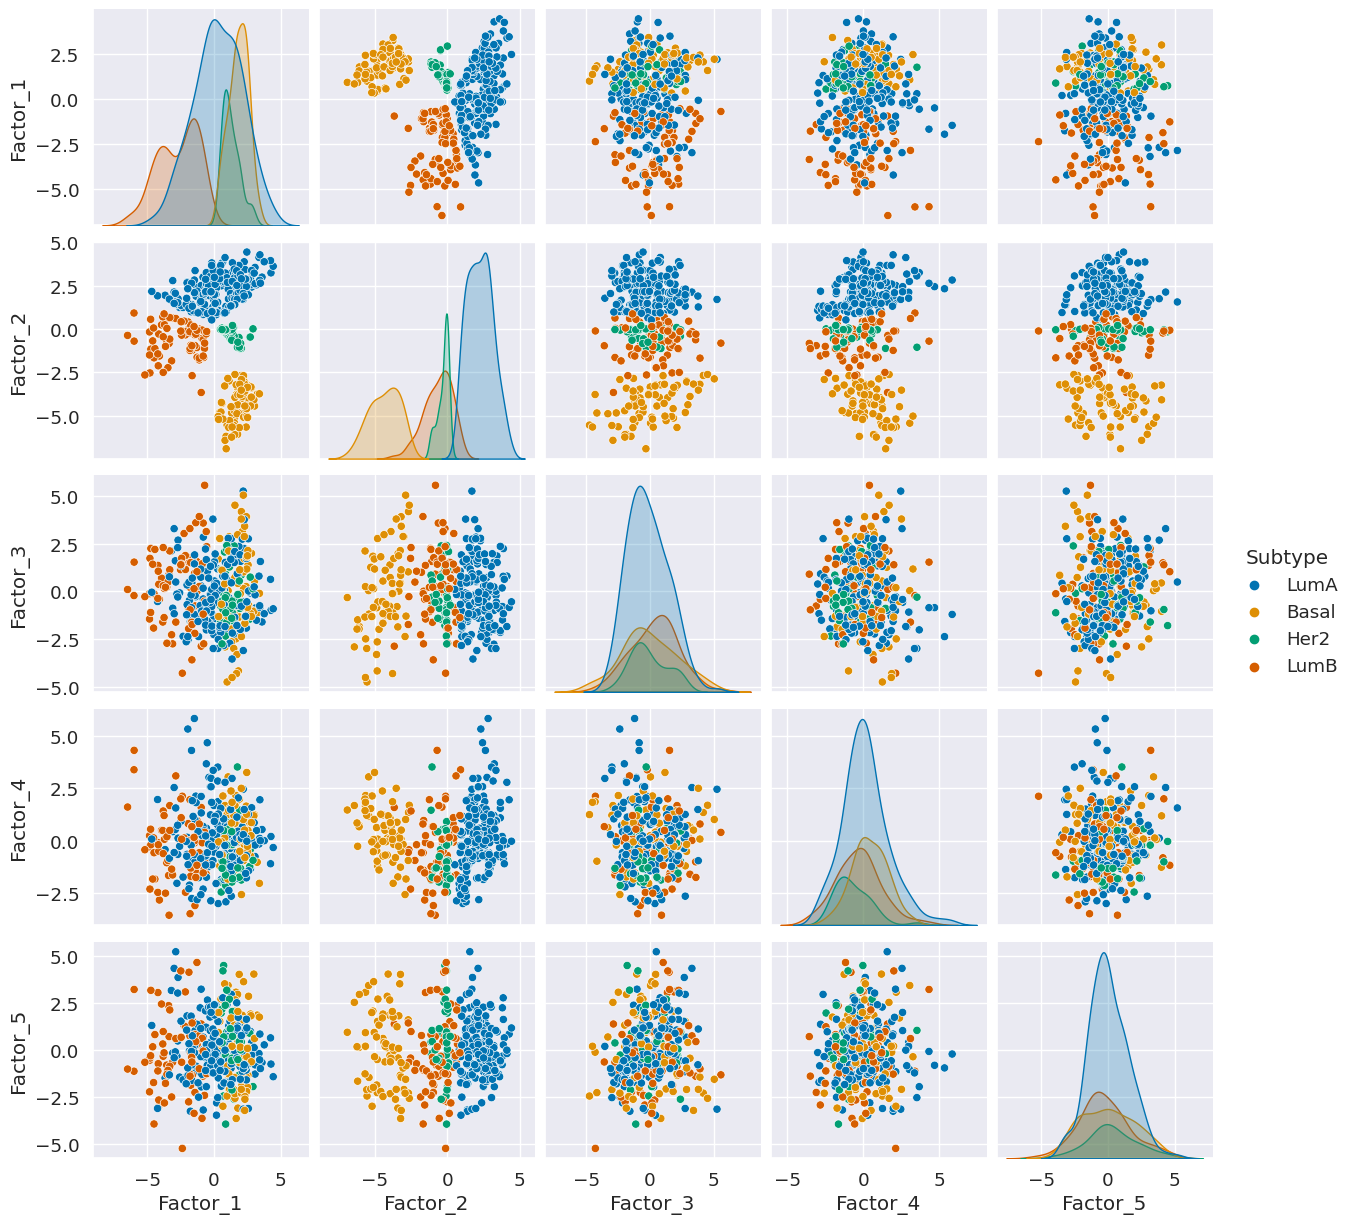

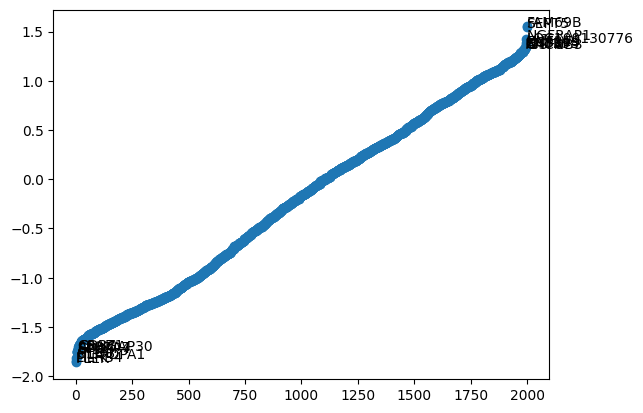

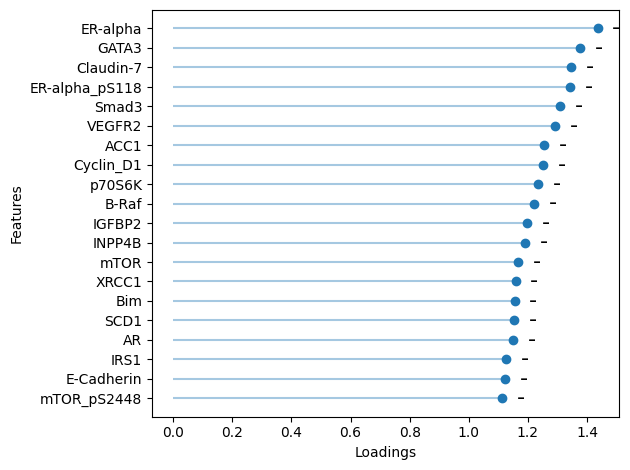

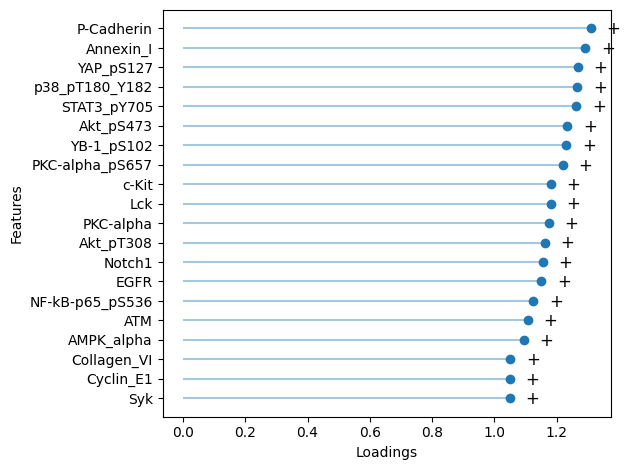

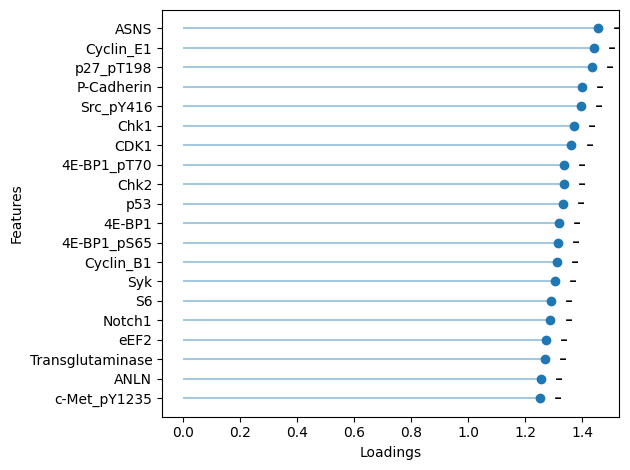

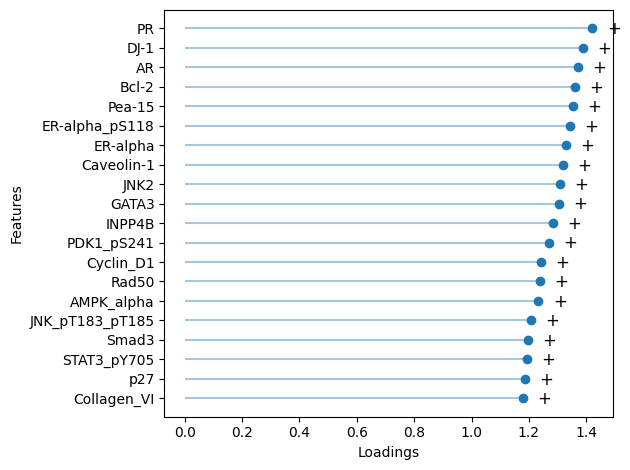

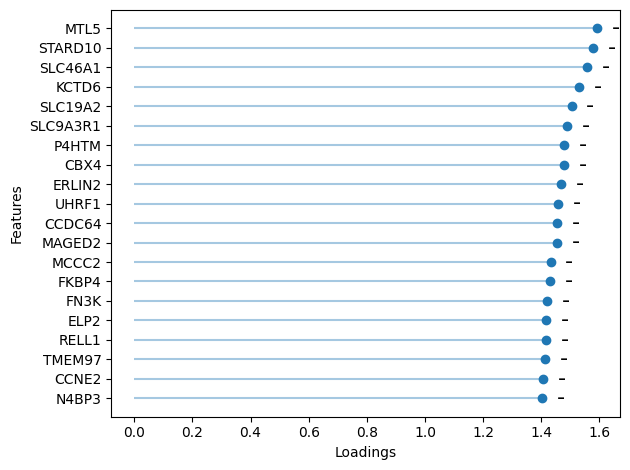

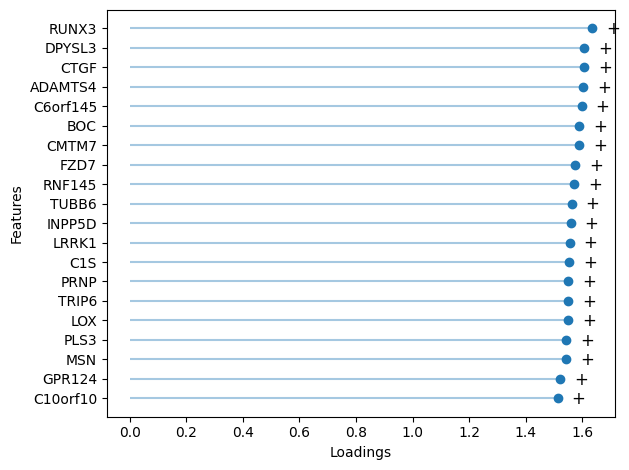

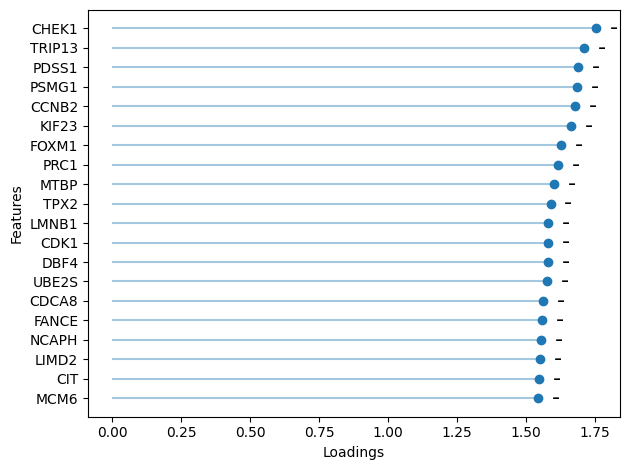

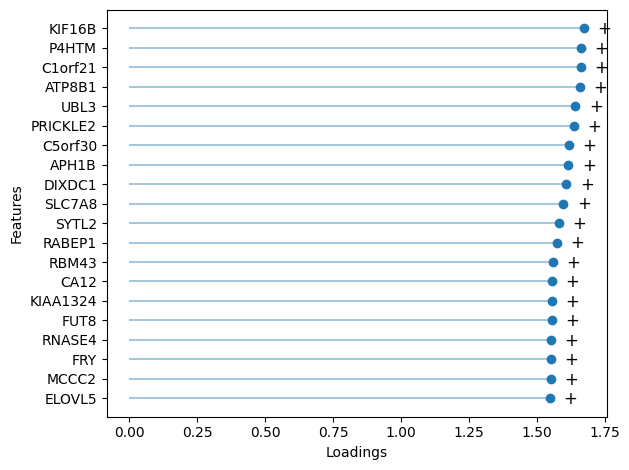

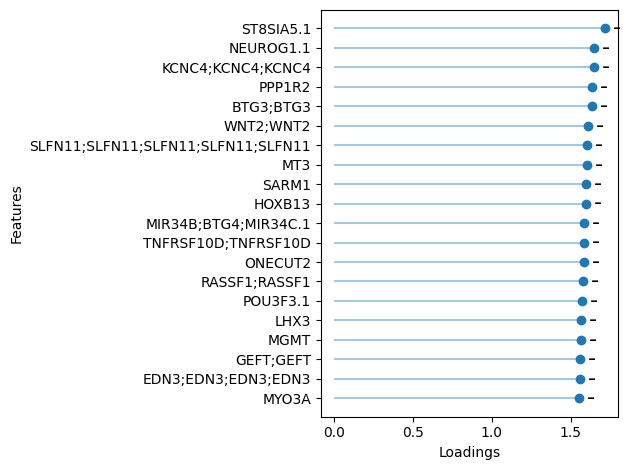

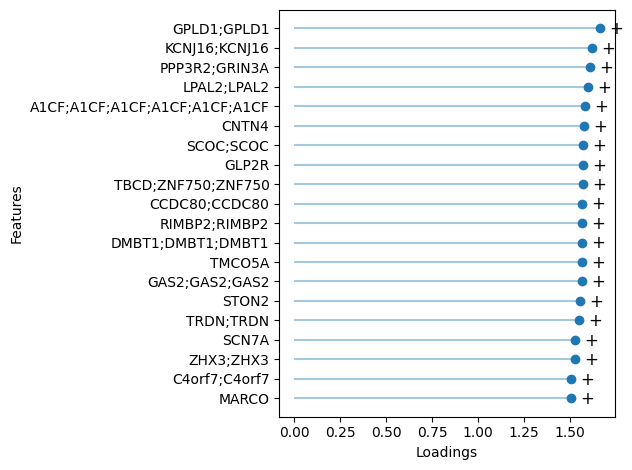

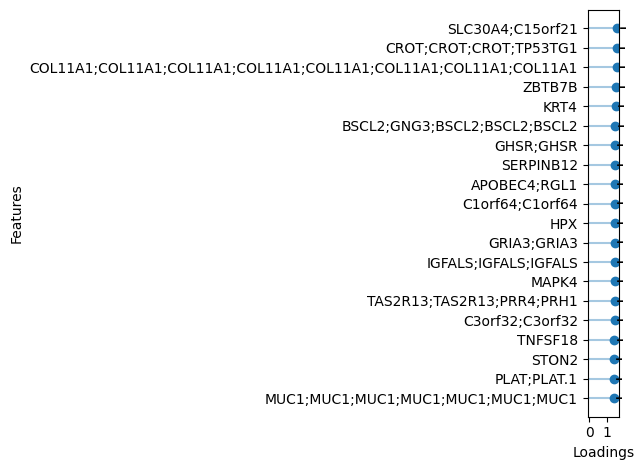

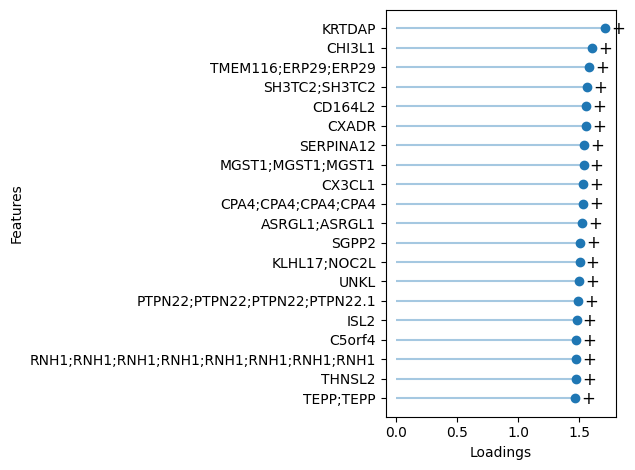

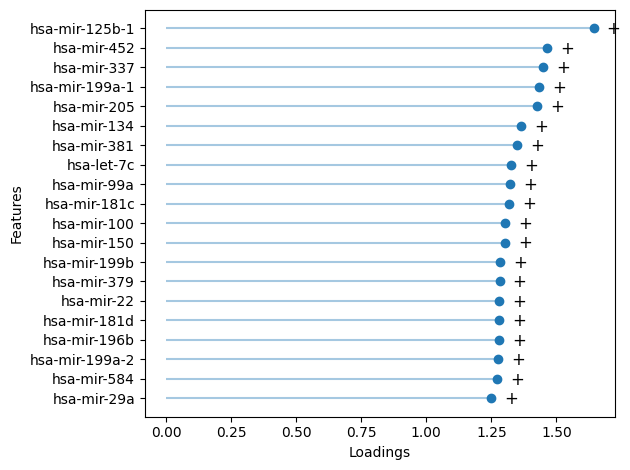

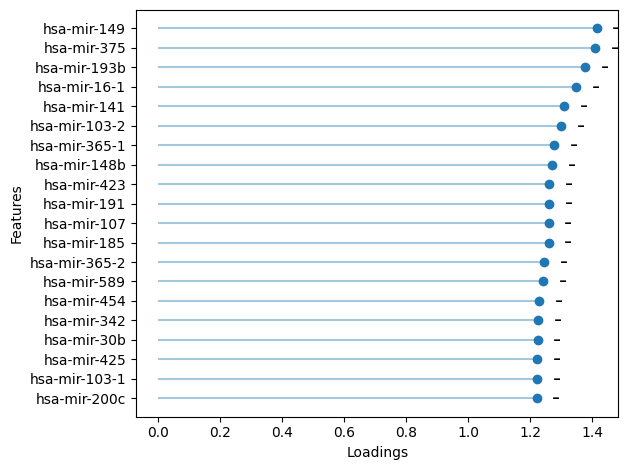

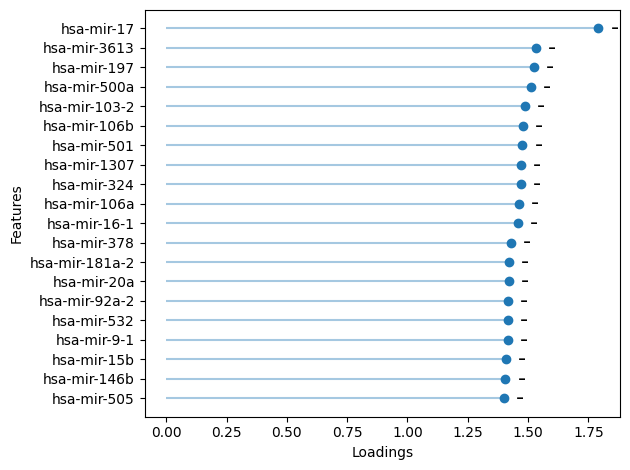

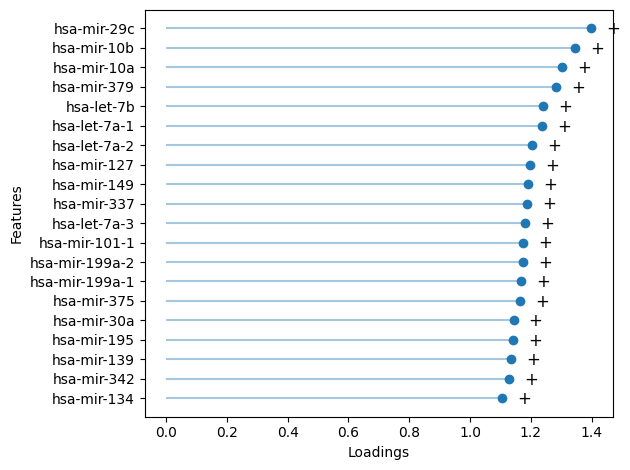

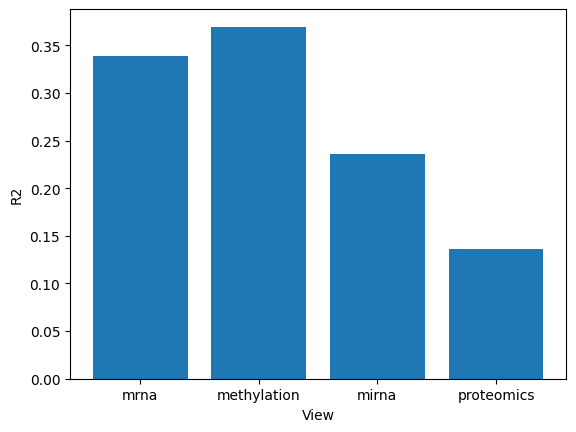

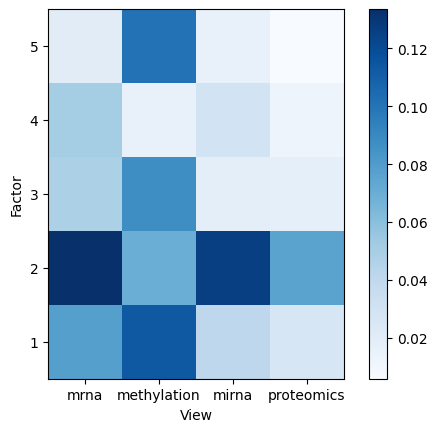

In [8]:
Z_pred = model.get_factors()
W_pred0 = model.get_loadings(view=0)
W_pred1 = model.get_loadings(view=1)
W_pred2 = model.get_loadings(view=2)
W_pred3 = model.get_loadings(view=3)
X_pred0 = model.get_Xpred(view=0)
X_pred1 = model.get_Xpred(view=1)
X_pred2 = model.get_Xpred(view=2)
X_pred3 = model.get_Xpred(view=3)

#X_pred2 = model.get_Xpred(view=2)
offsets = model.get_offsets()
X_p = model.get_Xpred()

# X_pred =   np.mean(samples["mean"].numpy(), axis=0)
# y_pred =   np.mean(samples["y_pred"].numpy(), axis=0)
# Z1_pred = np.mean(samples["Z1"].numpy(), axis=0)
# Z2_pred = np.mean(samples["Z2"].numpy(), axis=0)
# beta_pred = np.mean(samples["beta"].numpy(), axis=0)
X0 = X[0].numpy()
X1 = X[1].numpy()
X2 = X[2].numpy()
X3 = X[3].numpy()

# check reconstructions of data
fig, ax = plt.subplots(1)
ax.scatter(X0, X_pred0, alpha=0.01)
ax.plot([np.min(X_pred0), np.max(X0)], [np.min(X_pred0), np.max(X0)], color = "black")
ax.set_aspect('equal')
plt.xlabel("X")
plt.ylabel("X predicted")
plt.show()
plt.close()


# check reconstructions of data
fig, ax = plt.subplots(1)
ax.scatter(X1, X_pred1, alpha=0.01)
ax.plot([np.min(X_pred1), np.max(X1)], [np.min(X_pred1), np.max(X1)], color = "black")
ax.set_aspect('equal')
plt.xlabel("X")
plt.ylabel("X predicted")
plt.show()
plt.close()

#check reconstructions of data
fig, ax = plt.subplots(1)
ax.scatter(X2, X_pred2, alpha=0.01)
ax.plot([np.min(X_pred2), np.max(X2)], [np.min(X_pred2), np.max(X2)], color = "black")
ax.set_aspect('equal')
plt.xlabel("X")
plt.ylabel("X predicted")
plt.show()
plt.close()

fig, ax = plt.subplots(1)
ax.scatter(X3, X_pred3, alpha=0.01)
ax.plot([np.min(X_pred3), np.max(X3)], [np.min(X_pred3), np.max(X3)], color = "black")
ax.set_aspect('equal')
plt.xlabel("X")
plt.ylabel("X predicted")
plt.show()
plt.close()

# plots first latent factor, vs latent factor that is most correlated with y. breaks if first |beta| is highest 
fig, ax = plt.subplots(1)
for i,sub in enumerate(subtypes):
    plot = ax.scatter(Z_pred[subtype["x"].values==sub,0],Z_pred[subtype["x"].values==sub,1], color=cblind_colors[i], label=sub)
ax.set_aspect('equal')
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("Factor1-2.png", dpi=400)
plt.show()
plt.close()

df = pd.DataFrame(Z_pred, columns=[f"Factor_{i+1}" for i in range(Z_pred.shape[1])])
df["Subtype"] = subtype["x"].values



sns.set(font_scale=1.2)
sns.pairplot(df, vars=df.columns[:-1], hue="Subtype", palette="colorblind")
plt.savefig("pairplot_tcga.png", dpi=400)
plt.show()
plt.close()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


W0 = pd.DataFrame(W_pred0, columns = rna.columns)
W1 = pd.DataFrame(W_pred1, columns = meth.columns)
W2 = pd.DataFrame(W_pred2, columns = mirna.columns)
W3 = pd.DataFrame(W_pred3, columns = prot.columns)

# matplotlib.rc('ytick', labelsize=9) 
# matplotlib.rc('xtick', labelsize=9) 

plot_weights(W0, factor=4)

plot_top_weights(W3,factor=0,top_n=20 ,sign="-")

plot_top_weights(W3, factor=0, top_n = 20 , sign="+", highlight = ["ER-alpha", "GATA3", "AR", "PR", "INPP4B", "Bcl-2"])
plt.savefig("factor1_prot_+.png", dpi=400)

plot_top_weights(W3,factor=1,top_n=20 ,sign="-", highlight=["Caveolin-1"])
plt.savefig("factor2_prot_-.png", dpi=400)

plot_top_weights(W3, factor=1, top_n = 20 , sign="+", highlight=["HER2"])
plt.savefig("factor2_prot_+.png", dpi=400)


plot_top_weights(W0,factor=0,top_n=20 ,sign="-")
plot_top_weights(W0, factor=0, top_n = 20 , sign="+", highlight=["XBP1", "CA12"])
plt.savefig("factor1_mrna_+.png", dpi=400)

plot_top_weights(W0,factor=1,top_n=20 ,sign="-")
plot_top_weights(W0, factor=1, top_n = 20 , sign="+")

plot_top_weights(W1,factor=0,top_n=20 ,sign="-")
plot_top_weights(W1, factor=0, top_n = 20 , sign="+")

plot_top_weights(W1,factor=1,top_n=20 ,sign="-")
plot_top_weights(W1, factor=1, top_n = 20 , sign="+", highlight = ["HOXD9", "ZNF154;ZNF154"])

plot_top_weights(W2,factor=0,top_n=20 ,sign="+")
plot_top_weights(W2,factor=0,top_n=20 ,sign="-")
plot_top_weights(W2,factor=1,top_n=20 ,sign="-")
plot_top_weights(W2,factor=1,top_n=20 ,sign="+")

plot_variance_explained_view(model, X)
plt.savefig("total_variance_explained.png", dpi=400)

plot_variance_explained(model, X)
plt.savefig("factor_variance_explained.png", dpi=400)